## Use case Overview : 
The goal of this notebook is to predict NYC taxi trips duration. \
We use data related to yellow or green taxi in order to train simple model for the prediction.\
In this notebook, we use January 2021 yellow taxi data to train models and test (make predictions) on february data.

**The features for model training** : Usefull variables related to the trip itself \
**The target to predict** : The trip duration

### Data : 
The data can be downloaded following this [link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

**Info** : <p style=color:green>Using large amount of data in jupyter notebook, some cell can take some time to run<p/>

# 1 - Load data

In [2]:
train_df = pd.read_parquet("../00-data/yellow_tripdata_2021-01.parquet")

In [3]:
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369769 entries, 0 to 1369768
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1369769 non-null  int64         
 1   tpep_pickup_datetime   1369769 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1369769 non-null  datetime64[ns]
 3   passenger_count        1271417 non-null  float64       
 4   trip_distance          1369769 non-null  float64       
 5   RatecodeID             1271417 non-null  float64       
 6   store_and_fwd_flag     1271417 non-null  object        
 7   PULocationID           1369769 non-null  int64         
 8   DOLocationID           1369769 non-null  int64         
 9   payment_type           1369769 non-null  int64         
 10  fare_amount            1369769 non-null  float64       
 11  extra                  1369769 non-null  float64       
 12  mta_tax                13697

In [5]:
train_df.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64

# 2 - Prepare the data

## 2-1 Compute the target

The dataset contains pickup and dropoff time but not the duration itself. \
We are computing a taxi trip duration in minutes using this two variables.

In [6]:
def compute_target(df):
    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["duration"] = df["duration"].dt.total_seconds() / 60
    return df


train_df = compute_target(train_df)

We can visualise how the duration is distributed : 

In [7]:
train_df["duration"].describe()

count    1.369769e+06
mean     1.391168e+01
std      1.312006e+02
min     -1.350846e+05
25%      5.566667e+00
50%      9.066667e+00
75%      1.461667e+01
max      2.881770e+04
Name: duration, dtype: float64

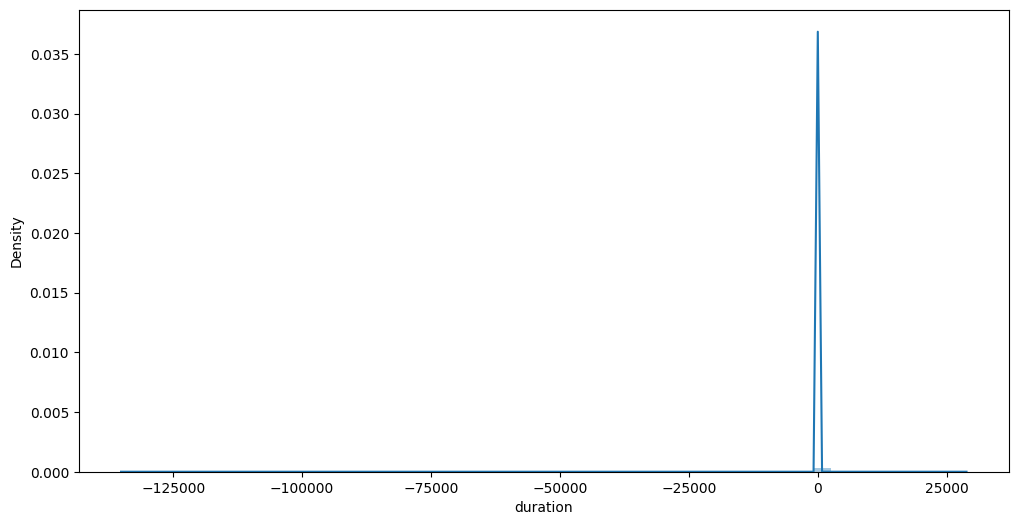

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.distplot(train_df.duration, ax=ax);

We can notice that there are negative durations or trips that last 6 hours. \
Let's remove outliers and reduce the scope to trips between 1 minute and 1 hour

In [9]:
MIN_DURATION = 1
MAX_DURATION = 60


def filter_outliers(df, min_duration=MIN_DURATION, max_duration=MAX_DURATION):
    df = df[df["duration"].between(min_duration, max_duration)]
    return df


train_df = filter_outliers(train_df)

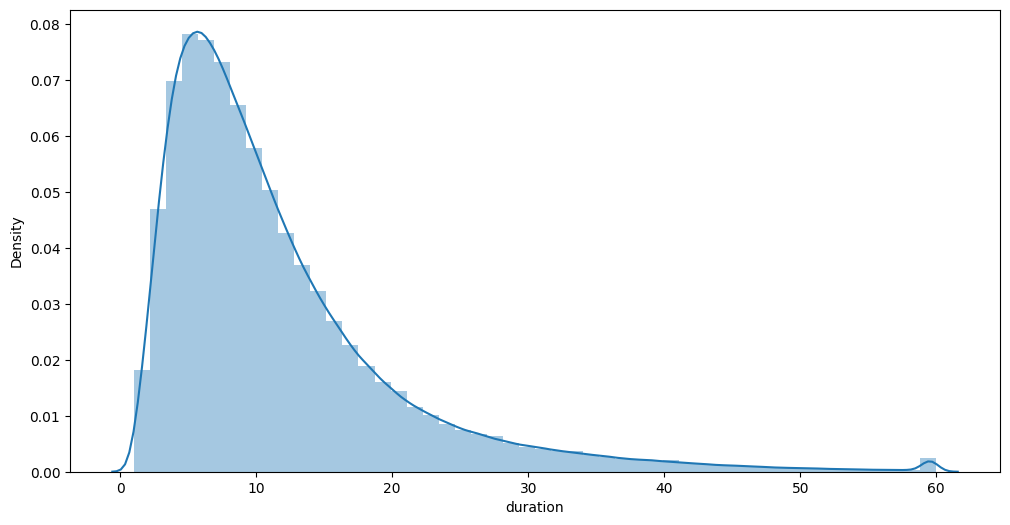

In [10]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.distplot(train_df.duration, ax=ax);

## 2-2 Prepare features

### 2-2-1 Categorical features

Lets encode variables with discrete values as string and then, extract features and target in order to train models

In [11]:
CATEGORICAL_COLS = ["PULocationID", "DOLocationID", "passenger_count"]


def encode_categorical_cols(df):
    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].fillna(-1).astype("int")
    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype("category")
    return df


train_df = encode_categorical_cols(train_df)

In [12]:
def extract_x_y(df, dv=None):
    dicts = df[CATEGORICAL_COLS].to_dict(orient="records")
    if dv is None:
        dv = DictVectorizer()
        dv.fit(dicts)
    X = dv.transform(dicts)
    y = df["duration"].values
    return X, y, dv


X_train, y_train, dv = extract_x_y(train_df)

# 3 - Train model

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

# 4 - Evaluate model

## 4-1 On train data

In [14]:
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

6.782410878595996

## 4-2 On test data

In [15]:
test_df = pd.read_parquet("../00-data/yellow_tripdata_2021-02.parquet")

In [16]:
test_df = compute_target(test_df)
test_df = filter_outliers(test_df)
test_df = encode_categorical_cols(test_df)
X_test, y_test, _ = extract_x_y(test_df, dv=dv)

In [17]:
y_pred_test = lr.predict(X_test)
mean_squared_error(y_test, y_pred_test, squared=False)

7.371085648147382